## The central intuition about this idea is to see our documents as images

Convolution Idea: While for an image we move our conv filter horizontally as well as vertically, for text we fix kernel size to filter_size x embed_size, i.e. we are just going to move vertically down for the convolution taking look at multiple words at once.

In [1]:
cd ..

/home/neil/cloud/habitual_errors_NLP


In [2]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline
from haberrspd.__init__ import *
from haberrspd.__init_paths import data_root

# goto the correct folder just for practicality's sake

### **Convolutional Neural Networks for Sentence Classification** adapted for use with characters embeddings

In [8]:
import torchtext.data as data
import haberrspd.charCNN.mydatasets as mydatasets
import torch # To set the device
import datetime
import os
from haberrspd.charCNN.model import CNN_Text
import haberrspd.charCNN.train as train
from haberrspd.pdnet_flair import Config

In [9]:
args = Config(
    # Arguments
    batch_size = 64,
    lr=0.001,
    epochs=10,
    kernel_sizes = [3,4,5],
    kernel_num = 100,
    embed_dim=128,
    dropout=0.5,
    cuda = torch.cuda.is_available(),
    snapshot = None,
    static=False,
    predict=None,
    test=False,
    log_interval=1,
    test_interval=100,
    early_stop=1000,
    save_best=True,
    save_interval=500,
    save_dir = 'snapshot'
)

In [10]:
# In this example, words are embedded
def mr(text_field, label_field, **kargs):
    train_data, dev_data = mydatasets.MR.splits(text_field, label_field)
    text_field.build_vocab(train_data, dev_data)
    label_field.build_vocab(train_data, dev_data)
    train_iter, dev_iter = data.Iterator.splits(
                                (train_data, dev_data), 
                                batch_sizes=(args.batch_size, len(dev_data)),
                                **kargs)
    return train_iter, dev_iter

# load data
text_field = data.Field(lower=True)
label_field = data.Field(sequential=False)
# Data passed to model here 
train_iter, dev_iter = mr(text_field, 
                          label_field, 
                          device=torch.device('cuda'), 
                          repeat=False)

# update args and print
args.set("embed_num",len(text_field.vocab))
args.set("class_num",len(label_field.vocab) - 1)
args.set("save_dir", os.path.join(args.save_dir, 
                                  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))

downloading
extracting


In [ ]:
# In this example, each character is embedded


### Data-example here (task: infer if positive/negative)

In [19]:
train_iter.dataset.examples[0].text

['his',
 'best',
 'film',
 'remains',
 'his',
 'shortest',
 ',',
 'the',
 'hole',
 ',',
 'which',
 'makes',
 'many',
 'of',
 'the',
 'points',
 'that',
 'this',
 'film',
 'does',
 'but',
 'feels',
 'less',
 'repetitive',
 '']

In [6]:
args

{'batch_size': 64,
 'lr': 0.001,
 'epochs': 10,
 'kernel_sizes': [3, 4, 5],
 'kernel_num': 100,
 'embed_dim': 128,
 'dropout': 0.5,
 'cuda': True,
 'snapshot': None,
 'static': False,
 'predict': None,
 'test': False,
 'log_interval': 1,
 'test_interval': 100,
 'early_stop': 1000,
 'save_best': True,
 'save_interval': 500,
 'save_dir': 'snapshot/2019-06-05_15-00-47',
 'embed_num': 21114,
 'class_num': 2}

In [7]:
# model
cnn = CNN_Text(args)
if args.cuda:
    cnn = cnn.cuda()

In [ ]:
# train or predict
if args.predict is not None:
    label = train.predict(args.predict, cnn, text_field, label_field, args.cuda)
    print('\n[Text]  {}\n[Label] {}\n'.format(args.predict, label))
elif args.test:
    try:
        train.eval(test_iter, cnn, args) 
    except Exception as e:
        print("\nSorry. The test dataset doesn't exist.\n")
else:
    print()
    try:
        train.train(train_iter, dev_iter, cnn, args)
    except KeyboardInterrupt:
        print('\n' + '-' * 89)
        print('Exiting from training early')

## **Character-level Convolutional Networks for Text Classification**

In [3]:
from haberrspd.pdnet_flair import Config, make_train_test_dev
from haberrspd.charCNN.auxiliary import make_MJFF_data_loader
from haberrspd.charCNN.train import run
import torch
import pandas as pd

In [6]:
# For deploy version, all of this will be placed in the parser
args = Config(
    # Model arguments
    val_path='haberrspd/charCNN/data/dev.csv',
    test_path='haberrspd/charCNN/data/test.csv',
    train_path='haberrspd/charCNN/data/train.csv',
    alphabet_path='haberrspd/charCNN/alphabet.json',# Where our alphabet lives
    load_very_long_sentences=False, # Temporary fix to remove unreasonably long sequences
    max_sample_length=8192, # The maximum length allowed for each training example
    num_workers=1,
    batch_size = 32,
    lr=0.001, # Learning rate
    epochs=50, # Set epochs here
    max_norm=400,
    optimizer='Adam',
    class_weight=None,
    dynamic_lr=False, # Dynamic learning rate, used for all but Adam
    milestones = [5,10,15],
    decay_factor = 0.5, # Rate by which we reduce the learning rate
    kernel_sizes = [3,4,5],
    kernel_num = 100,
    embed_dim=128,
    shuffle=False,
    dropout=0.5,
    cuda=True, # We have a GPU so let's use it
    verbose=False,
    continue_from='', # If we already trained a model we can continue from the stored one
    checkpoint=False,
    checkpoint_per_batch=10000,
    save_folder='haberrspd/charCNN/run_results',
    log_config=False,
    log_result=False,
    log_interval=1,
    val_interval=200,
    save_interval=1,
    plot_live=True, # If we want the losses to be plotted live
)

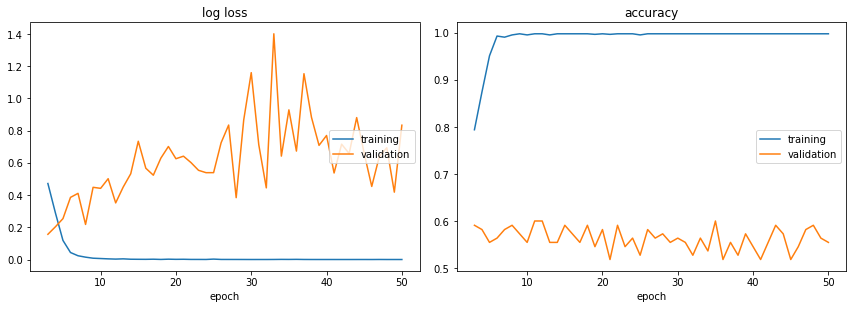

log loss:
training   (min:    0.000, max:    0.757, cur:    0.000)
validation (min:    0.157, max:    1.400, cur:    0.833)

accuracy:
training   (min:    0.631, max:    0.998, cur:    0.998)
validation (min:    0.518, max:    0.618, cur:    0.555)


In [7]:
assert torch.cuda.is_available() is True
run(args)

In [18]:
import torch
import torch.nn as nn

In [12]:
batch_size = 70
x = torch.ones(2**13, batch_size, 50) # Input    
m = nn.Sequential(
    nn.Conv1d(batch_size, 64, kernel_size=16, stride=1), # Function
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=3,stride=3)
)
out = m(x)
print(out.size())
# print(m)

torch.Size([8192, 64, 11])
